# Plotting land cover raster data with rioxarray and Matplotlib

Data used:

- Abera, Temesgen Alemayheu; Vuorinne, Ilja; Munyao, Martha; Pellikka, Petri; Heiskanen, Janne (2021), "Taita Taveta County, Kenya - 2020 Land cover map and reference database", Mendeley Data, V2, doi: [10.17632/xv24ngy2dz.2](https://doi.org/10.17632/xv24ngy2dz.2) - CC-BY-4.0

In [1]:
# import libraries
import multiprocessing
import platform
import os
from zipfile import ZipFile, BadZipFile
from datetime import datetime, timezone

# Windows
if platform.system() == "Windows":
    import multiprocessing.popen_spawn_win32
# Linux/OSX
else:
    import multiprocessing.popen_spawn_posix

import threading
import xml.etree.ElementTree as ET

import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
import rioxarray as rxr
from dask.distributed import Client, LocalCluster, Lock
from dask.utils import SerializableLock

In [4]:
print("Last updated:", datetime.now(tz=timezone.utc))

Last updated: 2022-08-08 07:54:25.009388+00:00


In [18]:
# configure plot styles
plt.style.use("seaborn-whitegrid")
plt.rcParams["font.family"] = "Source Sans 3"
plt.rcParams["figure.dpi"] = 150
plt.rcParams["axes.grid"] = False
plt.rcParams["text.color"] = "darkslategrey"
plt.rcParams["axes.labelcolor"] = "darkslategrey"
plt.rcParams["xtick.labelcolor"] = "darkslategrey"
plt.rcParams["ytick.labelcolor"] = "darkslategrey"
plt.rcParams["figure.titleweight"] = "semibold"
plt.rcParams["axes.titleweight"] = "semibold"
plt.rcParams["figure.titlesize"] = "13"
plt.rcParams["axes.titlesize"] = "12"
plt.rcParams["axes.labelsize"] = "10"

In [2]:
# define data directories
DATA_DIR = os.path.join("data", "kenya_land_cover")
ZIP_FILE = DATA_DIR + ".zip"

In [4]:
# download data
URL = (
    "https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/" +
    "xv24ngy2dz-2.zip"
)
r = requests.get(URL, stream=True)

os.makedirs("data", exist_ok=True)

if r.status_code == 200:
    with open(ZIP_FILE, "wb") as filedl:
        for chunk in r.iter_content(chunk_size=1048676):
            filedl.write(chunk)
    print("Data downloaded:", datetime.now(tz=timezone.utc))
else:
    print("\nStatus code:", r.status_code)

In [5]:
# list of files in the ZIP archive
ZipFile(ZIP_FILE).namelist()

['xv24ngy2dz-2/Data/Land cover map /Landcover-cMfoO1.tif',
 'xv24ngy2dz-2/Data/Land cover map /ColorCode-ni1SIo.qml',
 'xv24ngy2dz-2/Data/Land cover map /Info-UBC9RP.txt',
 'xv24ngy2dz-2/Data/Reference Database for Accuracy Assessment/File.zip',
 'xv24ngy2dz-2/Data/Reference Database for Classification/File.zip']

In [6]:
# extract the archive
try:
    z = ZipFile(ZIP_FILE)
    z.extractall(DATA_DIR)
except BadZipFile:
    print("There were issues with the file", ZIP_FILE)

In [5]:
# define paths to the TIF and QML files
for i in ZipFile(ZIP_FILE).namelist():
    if i.endswith(".tif"):
        raster_file = os.path.join(DATA_DIR, i)
    elif i.endswith(".qml"):
        style_file = os.path.join(DATA_DIR, i)

In [6]:
# read the raster
# use Dask for parallel computing
# https://corteva.github.io/rioxarray/stable/examples/dask_read_write.html
with LocalCluster() as cluster, Client(cluster) as client:
    landcover = rxr.open_rasterio(
        raster_file,
        chunks=True,
        cache=False,
        masked=True,
        lock=False,
        # lock=Lock("rio-read", client=client)  # when too many file handles open
    )
    landcover.rio.to_raster(
        os.path.join(DATA_DIR, "dask_multiworker.tif"),
        tiled=True,
        lock=Lock("rio", client=client)
    )

In [7]:
landcover

<xarray.DataArray (band: 1, y: 5400, x: 6068)>
dask.array<open_rasterio-8d0aa256624fbb213f2f0630d554214c<this-array>, shape=(1, 5400, 6068), dtype=float32, chunksize=(1, 5400, 6068), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 37.58 37.58 37.58 37.58 ... 39.22 39.22 39.22 39.22
  * y            (y) float64 -2.683 -2.683 -2.683 ... -4.137 -4.138 -4.138
    spatial_ref  int64 0
Attributes:
    RepresentationType:      THEMATIC
    STATISTICS_COVARIANCES:  1.218022624508617
    STATISTICS_MAXIMUM:      14
    STATISTICS_MEAN:         5.580012913879
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       1.1036406228971
    scale_factor:            1.0
    add_offset:              0.0

In [8]:
landcover.rio.resolution()

(0.00026949458520105445, -0.00026949458520105445)

In [9]:
landcover.rio.bounds()

(37.583984352, -4.138089356, 39.21927749499999, -2.682818595914306)

In [10]:
landcover.rio.crs

CRS.from_epsg(4326)

In [11]:
# get unique value count for the raster
uniquevals = pd.DataFrame(np.unique(landcover, return_counts=True)).transpose()

# assign column names
uniquevals.columns = ["value", "count"]

# drop row(s) with NaN
uniquevals.dropna(inplace=True)

# convert value column to string (this is required for merging later)
uniquevals["value"] = uniquevals["value"].astype(int).astype(str)

In [12]:
uniquevals

,value,count
0,1,16621.0
1,2,33046.0
2,3,33286.0
3,4,981030.0
4,5,9219689.0
5,6,7721553.0
6,7,124588.0
7,8,871990.0
8,9,75661.0
9,10,10556.0


In [13]:
# read the QGIS style file containing the legend entries
tree = ET.parse(style_file)
root = tree.getroot()

# extract colour palette
pal = {}

for palette in root.iter("paletteEntry"):
    pal[palette.attrib["value"]] = palette.attrib

# generate data frame from palette dictionary
legend = pd.DataFrame.from_dict(pal).transpose()
legend = pd.DataFrame(legend)

# drop alpha column
legend.drop(columns="alpha", inplace=True)

# convert value column to string (this is required for merging later)
legend["value"] = legend["value"].astype(str)

In [14]:
legend

,value,label,color
1,1,Montane forest,#6ed277
2,2,Plantation forest,#4d7619
3,3,Riverine forest,#27f90c
4,4,Thicket,#fd8e07
5,5,Shrubland,#fac597
6,6,Grassland,#aaec85
7,7,Agroforestry,#4df3ef
8,8,Cropland,#f9ed25
9,9,Sisal,#840bfe
10,10,Builtup,#833023


In [15]:
# merge unique values data frame with legend
uniquevals = uniquevals.merge(legend, on="value")

# calculate percentage based on count
uniquevals["percentage"] = (
    uniquevals["count"] / uniquevals["count"].sum() * 100
)
uniquevals["percentage"] = uniquevals["percentage"].astype(int)

# sort by count
uniquevals.sort_values("count", ascending=False, inplace=True)

In [16]:
uniquevals

,value,count,label,color,percentage
4,5,9219689.0,Shrubland,#fac597,47
5,6,7721553.0,Grassland,#aaec85,40
3,4,981030.0,Thicket,#fd8e07,5
7,8,871990.0,Cropland,#f9ed25,4
6,7,124588.0,Agroforestry,#4df3ef,0
12,13,89317.0,Baresoil,#ee15ca,0
8,9,75661.0,Sisal,#840bfe,0
11,12,73355.0,Wetland,#4dc4f3,0
10,11,34500.0,Waterbody,#3630ee,0
2,3,33286.0,Riverine forest,#27f90c,0


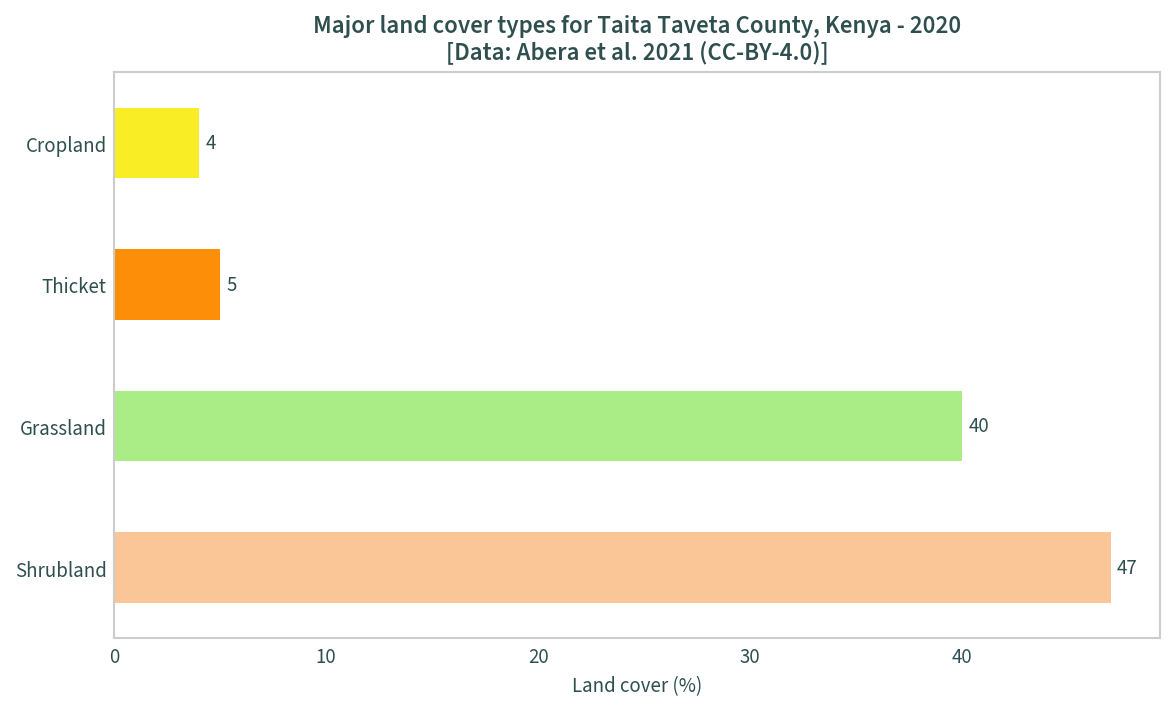

In [19]:
# plot the major land cover types, i.e. percentage > 0
mask = uniquevals["percentage"] > 0
uniquevals_sig = uniquevals[mask]

ax = uniquevals_sig.plot.barh(
    x="label", y="percentage", legend=False, figsize=(9, 5),
    color=uniquevals_sig["color"]
)

ax.bar_label(ax.containers[0], padding=3)
plt.title(
    "Major land cover types for Taita Taveta County, Kenya - 2020" +
    "\n[Data: Abera et al. 2021 (CC-BY-4.0)]"
)
plt.ylabel("")
plt.xlabel("Land cover (%)")
plt.show()

In [20]:
# convert values to integer and sort
uniquevals["value"] = uniquevals["value"].astype(int)
uniquevals.sort_values("value", inplace=True)

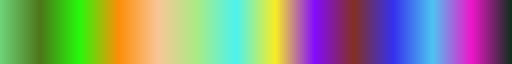

In [21]:
# create a continuous colourmap for the plot
colours = list(uniquevals["color"])
nodes = np.array(uniquevals["value"])
# normalisation
nodes = (nodes - min(nodes)) / (max(nodes) - min(nodes))
colours = LinearSegmentedColormap.from_list(
    "LCM", list(zip(nodes, colours))
)
colours

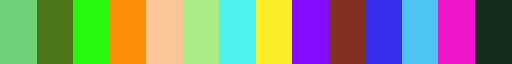

In [22]:
# create a discrete colourmap for the legend
col_discrete = ListedColormap(list(uniquevals["color"]))
col_discrete

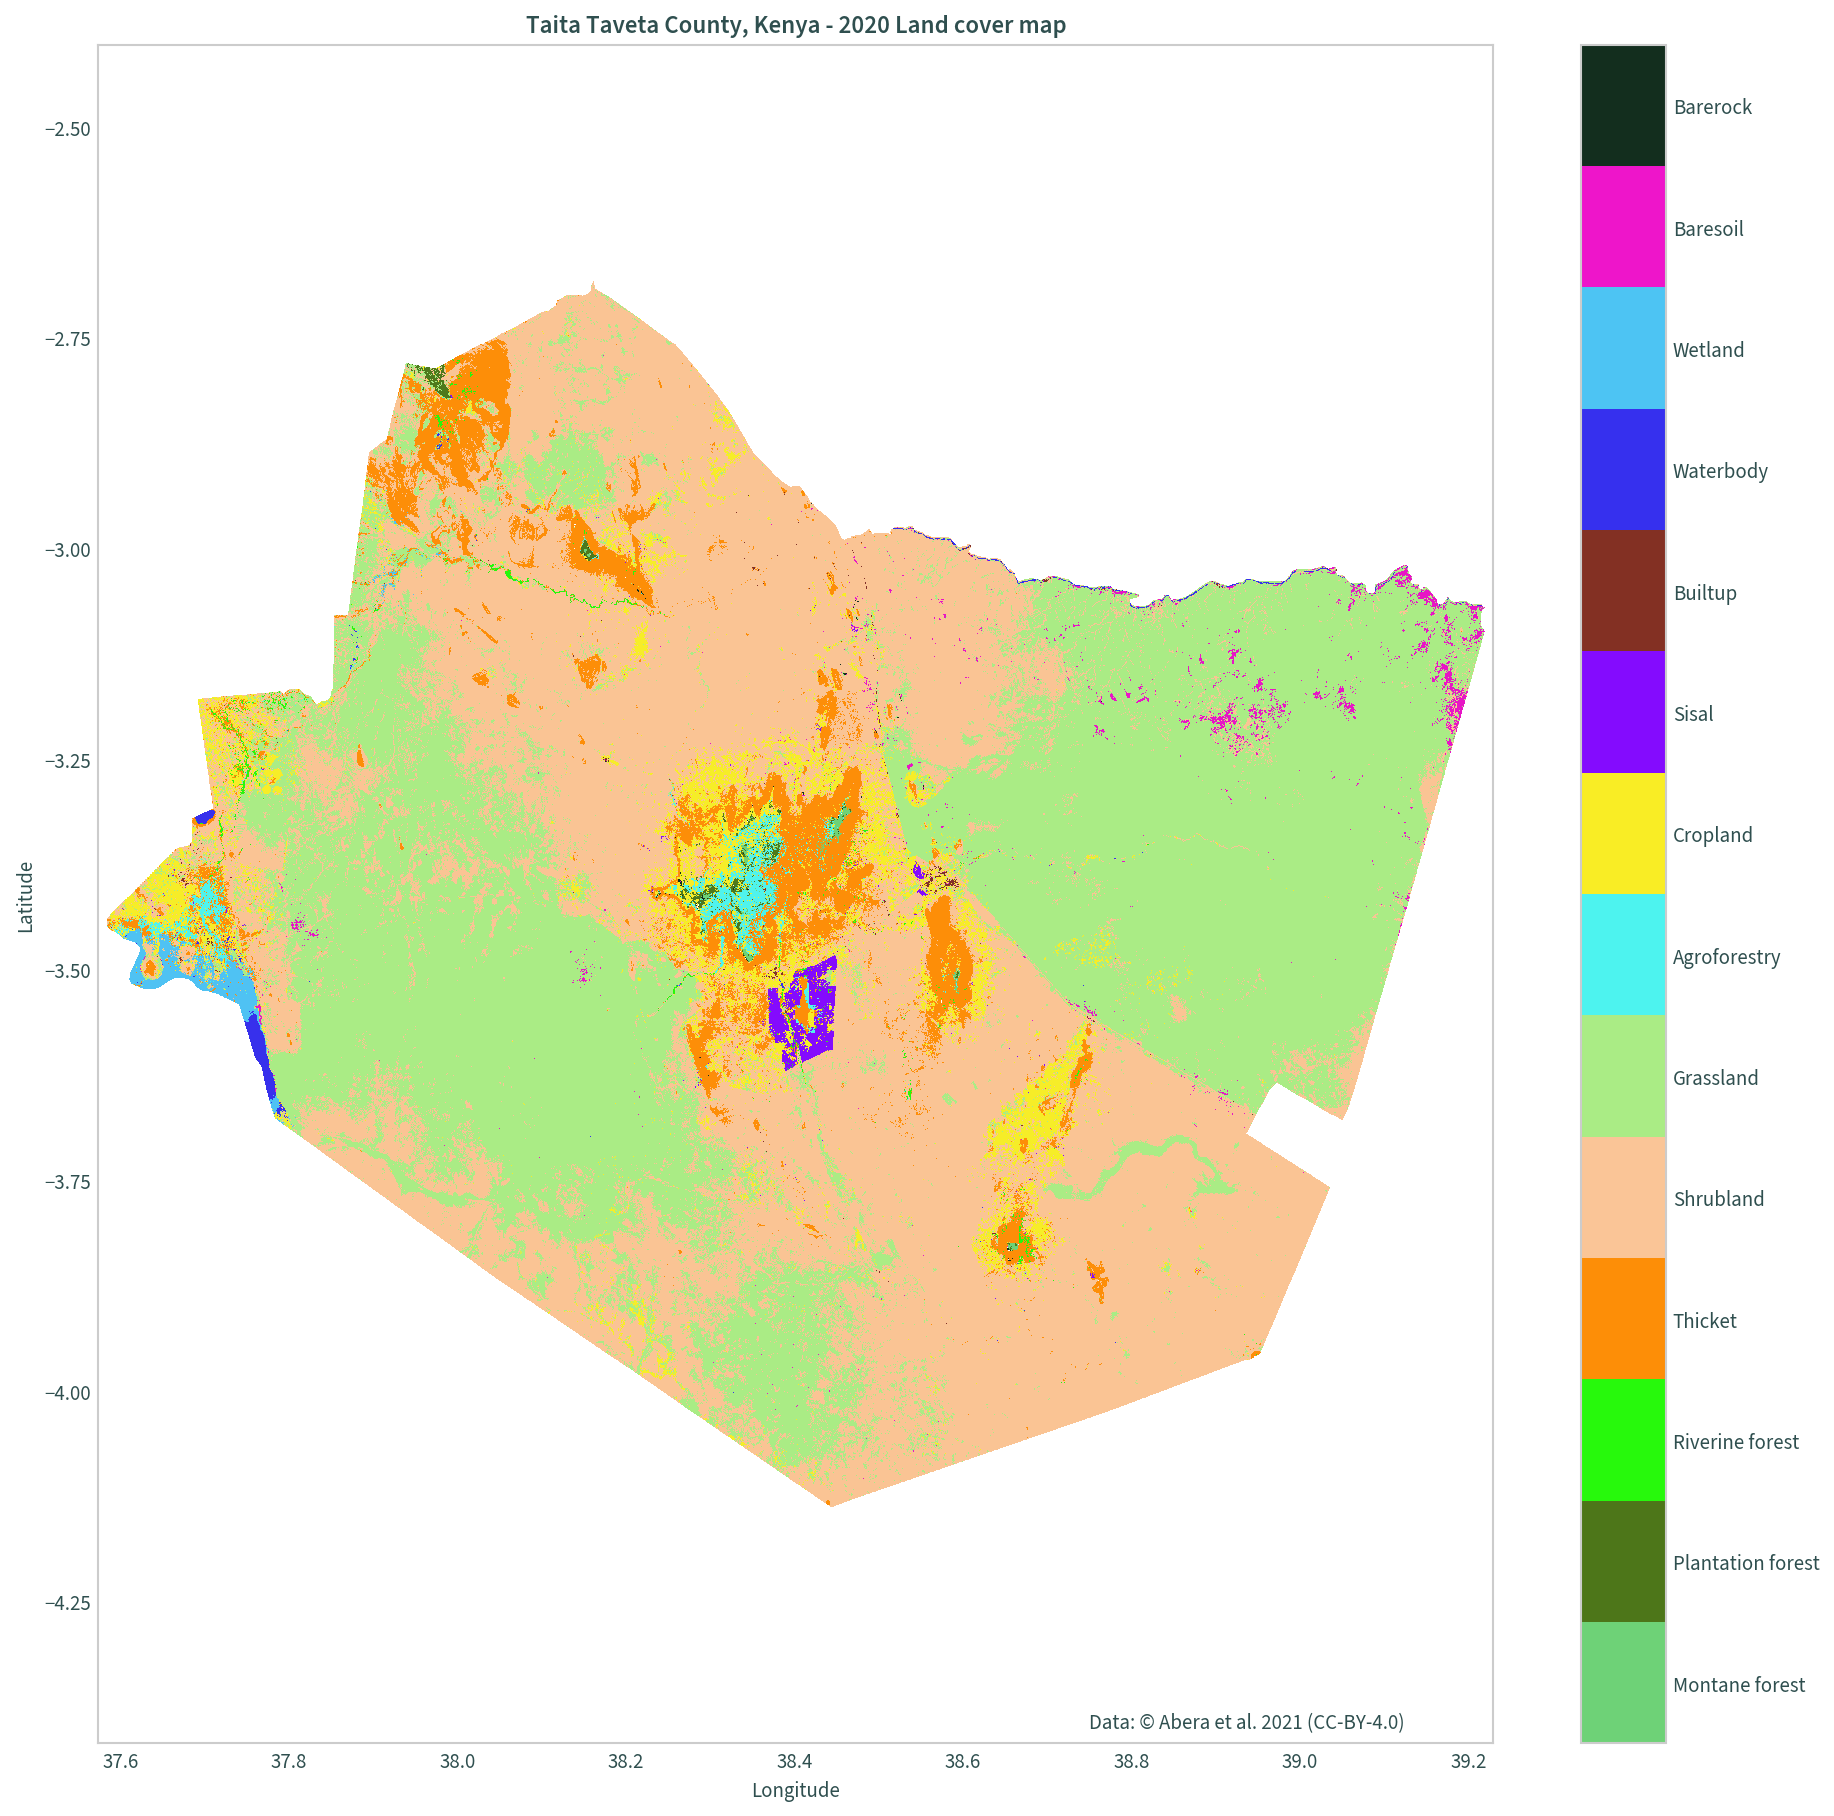

In [23]:
# create a dummy plot for the discrete colour map as the legend
img = plt.figure(figsize=(15, 15))
img = plt.imshow(np.array([[0, len(uniquevals)]]), cmap=col_discrete)
img.set_visible(False)

# assign the legend's tick labels
ticks = list(np.arange(.5, len(uniquevals) + .5, 1))
cbar = plt.colorbar(ticks=ticks)
cbar.ax.set_yticklabels(list(uniquevals["label"]))

landcover.plot(add_colorbar=False, cmap=colours)

plt.axis("equal")
plt.xlim(landcover.rio.bounds()[0] - .01, landcover.rio.bounds()[2] + .01)
plt.ylim(landcover.rio.bounds()[1] - .01, landcover.rio.bounds()[3] + .01)

plt.title("Taita Taveta County, Kenya - 2020 Land cover map")
plt.text(38.75, -4.4, "Data: © Abera et al. 2021 (CC-BY-4.0)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()